# General intro 👋

Find the repo of this notebook at [autoencoders](https://github.com/arrrrrmin/autoencoders). 

**Reach out to me for question or ideas**:
You can mail me, message me on mastodo [@arrrrrmin@chaos.social](https://chaos.social/@arrrrrmin) just open an issue in the [autoencoders](https://github.com/arrrrrmin/autoencoders)-repo. I also try to update this with more recent architectures. For exciting recommendations open an issue, maybe I'm able to add the architecture.

**A few questions befor we start**:
* Is there any experience in machine learning?
* Can any imagine to write a thesis about this topic?
* Has anyone tried any prompts with the hyped *GPT-4* or *Stable Diffusion* models?
* What operating systems are running?

# Unsupervised Learning - An introduction

Unsupervised learning is a type of machine learning where the algorithm learns patterns from unlabelled data. The goal of unsupervised learning is to discover hidden structures or patterns in the data. Techniques like clustering and dimensionality reduction are strongly related and user in unsupervised learning.

While dimension reduction aims to make high-dimensional data manageable, clustering seeks to find the boundary for differentiation within the data. Common dimension reduction techniques are principal component analysis (PCA), based on linear transformation. The goal is to find the desired number of components by the eigenvectors of the covariance matrix of the data.
Other methods include Uniform Manifold Approximation and Projection (UMAP) or t-distributed stochastic neighbor embedding (tSNE). Dimensionality reduction is often used in machine learning to visualize high dimensional features.

Clustering on the other hand tries to optimize a number of cluster centroids on the data to describe it as groups. Clustering can be used to find shared characteristics in features or classify the data into classes (or groups). There is a number of different types of clustering methods. Connectivity models, centroid models, distribution models or density models. Well known clustering methods are KMeans, DBSCAN or MeanShift.

## Notation

| Symbol | Meaning |
|:--- | :--------------------------- |
| $x_{i}$ | The $i$th input vector in the training set of size $1024$ |
| $x'_{i}$ | Output vector corresponding to $i$ of size $1024$ |
| $N$ | Number of samples in the training set |
| $y_{i}$ | The $i$th target to compute loss function |
| $\hat{y}_{i}$ | The $i$th output corresponding to the $ith$ target |
| $g_{\phi}$ | Encoding module of varying architectures |
| $f_{\phi}$ | Decoding module reverse architecture of $g_{\phi}$ |
| $z$ | Latent coder of some tbd. dimension |
| $\alpha$ | Learning rate |
| $b$ | Bias term, added to the linear transformation |
| $A^{T}$ | Weight matrix $A$ in transposed form (swapping the dimensions) |
| $a_{j}^{(l)}$ | The $j$th activation in the $(l)$th layer |
| $p$ | Satisfied probability in range (0, 1) |
| $\hat{p}_{j}^{(l)}$ | The produced probability of $j$th activation in $(l)$th layer |

## On autoencoders

The basic goal of the autoencoder is to find an accurate low dimensional representation of the input $x_{i}$, be learning to encode $g_{\phi}$ and decode $f_{\phi}$ the input to latent space (latent code) and reverse decode this latent representation back to the input. The training goal is to obtain good reconstructions from the original input. If that's the case the encoder ($g_{\phi}$) can compress the input feature, while the decoder ($f_{\phi}$) can reconstruct the input ($x'$). After training the encoder can be used to find good low dimensional representations from the input space, for classification or other tasks. Whereas the decoder can be used to generate outputs from low dimensional inputs (a fundamental concept to Generative Adverserial Networks (GANs)).


![Simple autoencoder overview diagram](figures/SimpleAutoEncoder.png)

As the image above suggestes the first network we want to observe is a simple 1-layer autoencoder. It works with a linear layer on the en- and decoding side. This is not a requirement, there are many other autoencoder architectures in the literature. Other known Autencoder layers are Convolutional or Long-Short-Term-Memory (LSTM) layers.

## Let's do some hands-on example

In [3]:
import matplotlib.pyplot as plt

from autoencoders.data import MNISTDataModule
from autoencoders.models.simple import SimpleEncoder, SimpleDecoder, SimpleBlottleneck
from autoencoders.lightning_extension import AutoEncoder
from autoencoders.scripts import run

In [4]:
# Define a batch size & training size (None means give me all)
# Load the dataset and do some normalization and splitting (train, val, test)

batch_size = 32
training_size = None
datamodule = MNISTDataModule("./dataset/", batch_size, training_size)
datamodule.prepare_data()
datamodule.setup(stage="fit")
len(datamodule.mnist_train)

55000

In [5]:
image, label = datamodule.mnist_train[0]
print(image)
print(image.shape)
print(image.max(), image.min())

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 32, 32])
tensor(1.) tensor(0.)


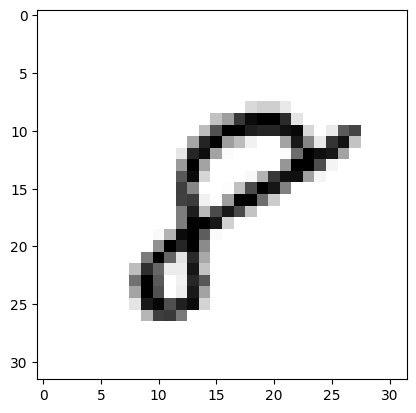

In [6]:
# Some jupyter magic
%matplotlib inline

# Change the number to see what other examples exist in the dataset
image, _ = datamodule.mnist_train[54999]

plt.imshow(image.squeeze(), cmap="binary")

Ok, we know our dataset contains images of 32 by 32 (originally thats 28, 28 but we padded (32, 32) to better fit memory bit ranges). From the autoencoder overview *diagram* above, we don't see how large the input size is and to what size latent code dimension $z$ it is reduced. We need to define this. Also we need to find a good learning rate ($\alpha$). Finding a good learning rate for your model is always related to the data at hand. Obtaining a good learning rate is still a research topic.

**Recall**: The learning rate can be roughly viewed as the amount of how much to apply the gradients to your weights. So to say how large step you do with each learning step, using the optimization algorithm. For a deeper dive see ["On the importance of initialization and momentum in deep learning"](https://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf) and ["ADAM: A Method for Stochastic Optimization"](https://arxiv.org/abs/1412.6980).

**Shortly off road**: Randomly searching for *"learning rate"* in the title of arxiv.org papers already gives you an idea of how *unsolved* the question of a good learning rate is. 

Here the $0.01$ is fine. Might not be the best but it's good. In practise often this is found by simply trying it out and with a reasonable value people proceed and further optimize it in the end with hyperparameter searching.

In [48]:
input_shape = (1, 32, 32)
latent_dim = 20
alpha = 0.01
encoder = SimpleEncoder(input_shape, latent_dim)
decoder = SimpleDecoder(latent_dim, input_shape)
bottleneck = SimpleBlottleneck(latent_dim)
model = AutoEncoder(encoder, bottleneck, decoder, lr=alpha, recon_loss="rmse", prevent_tb_logging=True)
print(model)

AutoEncoder(
  (encoder): SimpleEncoder(
    (layer): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1024, out_features=20, bias=True)
      (2): ReLU()
    )
  )
  (bottleneck): SimpleBlottleneck()
  (decoder): SimpleDecoder(
    (layer): Sequential(
      (0): Linear(in_features=20, out_features=1024, bias=True)
      (1): Sigmoid()
    )
  )
  (criterion_recon): MSELoss()
)


Let's shorty tough on linear transformations. As mentioned above there are other ways to build autoencoders, but we'll focus on linear layers as they are the easiest to understand. The `nn.Linear` layer inside `SimpleEncoder` and `SimpleDecoder` applies $y=xA{T}+b$, where $A^{T}$ is the transposed weight matrix, $x$ is the input and $b$ the bias term. Our goal is to learn a good matrix of weights $A$, to accuratly encoder $x$ as $z$.
We do the same in reverse for the decoder to reconstruct the latent code $z$ back to $x$'s size. 

In [37]:
# A very basic linear transformation example

import torch
import numpy as np

inputs = torch.rand((32, 20))

L1 = torch.nn.Linear(20, 18, bias=True)
print(L1)
print("L1.weight", L1.weight.shape)
print("L1.bias", L1.bias.shape)

x = L1(inputs)
print("Sum of L1 output:", x.sum().item())

x = torch.mm(inputs, L1.weight.T) + L1.bias
print("Sum of matrix multiplication:", x.sum().item())

# Another matrix multiplication example
A1 = torch.randint(0, 10, (2, 3))
A2 = torch.randint(0, 10, (3, 2))
print("Weight matrix A1:\n", A1)
print("Weight matrix A2:\n", A2)

# torch.mm((n,k), (k,m)) -> (n,m)
print("(n,k), (k,m)) -> (n,m)")
y = torch.mm(A1, A2)
print("Shape of y mm(A1,A2)", y.shape)

Linear(in_features=20, out_features=18, bias=True)
L1.weight torch.Size([18, 20])
L1.bias torch.Size([18])
Sum of L1 output: -65.53382873535156
Sum of matrix multiplication: -65.53382873535156
Weight matrix A1:
 tensor([[1, 0, 6],
        [5, 6, 5]])
Weight matrix A2:
 tensor([[5, 0],
        [2, 7],
        [6, 9]])
(n,k), (k,m)) -> (n,m)
Shape of y mm(A1,A2) torch.Size([2, 2])


In order to find the weights that handle our problem well, we need to define a cost function, so we can iterate to a good enough model.

Inside the `AutoEncoder` class there's a loss function defined. It's called *root mean square error* (RMSE).

$L = \sqrt{(\hat{y})^{2} - x}$, where $x$ are the inputs and $\hat{y}$ are the outputs of the decoder. Size we know our inputs are scaled between $0$ and $1$ we can also use *binary cross entropy* as loss function, but for now that fine.

For the bce we'd need to sum over rows and cols of the image and compute the loss over every pixel: $L_{BCE} = \frac{1}{N}\sum_{1}^{N}\sum_{1}^{h \cdot c}BCE(\hat{x}_{i}^{j}, x_{i}^{j})$.

In [38]:
# We need some jupyter magic to plot inline
%matplotlib inline

# Increase the number of epochs for more accurate results
# Note that the model will most likely converge around 20-35 epochs.
epochs = 5
logger = run.build_logger("simpleautoencoder", datamodule_name="MNIST", task="reconstruction")
run._train(model, logger, datamodule, epochs)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params
------------------------------------------------------
0 | encoder         | SimpleEncoder     | 20.5 K
1 | bottleneck      | SimpleBlottleneck | 0     
2 | decoder         | SimpleDecoder     | 21.5 K
3 | criterion_recon | MSELoss           | 0     
------------------------------------------------------
42.0 K    Trainable params
0         Non-trainable params
42.0 K    Total params
0.168     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
/Users/arminmuller/Library/Caches/pypoetry/virtualenvs/autoencoders-qHSJ5McI-py3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arminmuller/Library/Caches/pypoetry/virtualenvs/autoencoders-qHSJ5McI-py3.11/lib/python3.11/site-packages/torch/__init__

''

## Deep Autoencoders

Until now we only had single layer networks, for en- and decoding. We can do this with multiple and have a deep learning network on both sides. This will improve the network since we have not one matrix of weight to take care of the operations but as many as we want to have. But be aware, if we take to many we overfit, meaning we know only the training dataset and cannot handle any other - related but not the same - images.

![Deep autoencoder overview diagram](figures/DeepAutoEncoder.png)

Green layers are encoders, while blues are decoding layers. On the left of green layers we see input sizes. On the right of the decoding layer we see the respective output sizes of each layer and as shown in the diagram each layer has it's own $A^{T}$ and $b$.



In [9]:
from autoencoders.models.deep import DeepEncoder, DeepDecoder

In [10]:
# Play a little with latent dimension and depth.
# If you just want faster results run it for 1 epoch and have a look.

input_shape = (1, 32, 32)
latent_dim = 20
depth = 3
alpha = 0.01
encoder = DeepEncoder(input_shape, depth, latent_dim)
decoder = DeepDecoder(latent_dim, depth, input_shape)
bottleneck = SimpleBlottleneck(latent_dim)
model = AutoEncoder(encoder, bottleneck, decoder, lr=alpha, noise_ratio=None, recon_loss="rmse", prevent_tb_logging=True)
print(model)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1024, out_features=341, bias=False)
    (1): BatchNorm1d(341, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Linear(in_features=341, out_features=113, bias=False)
    (1): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Linear(in_features=113, out_features=20, bias=True)
)
AutoEncoder(
  (encoder): DeepEncoder(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1024, out_features=341, bias=False)
        (1): BatchNorm1d(341, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Linear(in_features=341, out_features=113, bias=False)
        (1): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    

In [11]:
# We need some jupyter magic to plot inline
%matplotlib inline

epochs = 5
logger = run.build_logger("deepautoencoder", datamodule_name="MNIST", task="reconstruction")
run._train(model, logger, datamodule, epochs)

NameError: name 'datamodule' is not defined

## Denoising Autoencoder

The denoising autoencoder is the experiment to adjust the input with noise injection, so the image matricies recieved by the network are partially broken. The task for the network stays the same, but the comparison (loss calculations) are done on the original (non broken) inputs. The expectation is a denoising effect, as the model should learn to correct the noisy parts in the input image. 

![Denoising AutoEncoder](figures/DenoisingAutoEncoder.png)

The image shows the proceedure, where we want to decode the noisily encoded latent code $x'$ and compare it not with $\tilde{x}$ but with the original $x$.

> A question about the intuition, where is the denoising aspect learned, if we use the same architecture and process as with the deepautoencoder run?

In [7]:
from autoencoders.models.deep import DeepEncoder, DeepDecoder

In [8]:
input_shape = (1, 32, 32)
latent_dim = 20
depth = 3
alpha = 0.01
noise_ratio = 0.25
encoder = DeepEncoder(input_shape, depth, latent_dim)
decoder = DeepDecoder(latent_dim, depth, input_shape)
bottleneck = SimpleBlottleneck(latent_dim)
model = AutoEncoder(encoder, bottleneck, decoder, lr=alpha, noise_ratio=noise_ratio, recon_loss="rmse", prevent_tb_logging=True)
print(model)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1024, out_features=341, bias=False)
    (1): BatchNorm1d(341, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Linear(in_features=341, out_features=113, bias=False)
    (1): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Linear(in_features=113, out_features=20, bias=True)
)
AutoEncoder(
  (encoder): DeepEncoder(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1024, out_features=341, bias=False)
        (1): BatchNorm1d(341, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Linear(in_features=341, out_features=113, bias=False)
        (1): BatchNorm1d(113, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params
------------------------------------------------------
0 | encoder         | DeepEncoder       | 390 K 
1 | bottleneck      | SimpleBlottleneck | 0     
2 | decoder         | DeepDecoder       | 391 K 
3 | criterion_recon | MSELoss           | 0     
------------------------------------------------------
782 K     Trainable params
0         Non-trainable params
782 K     Total params
3.131     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val/reconstructions at 0


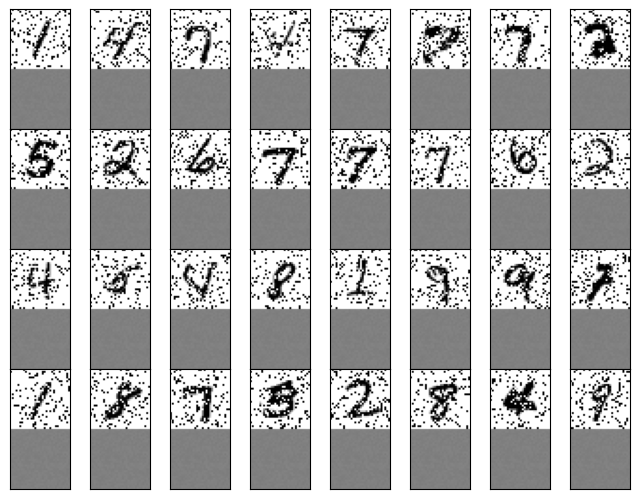

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val/reconstructions at 1719


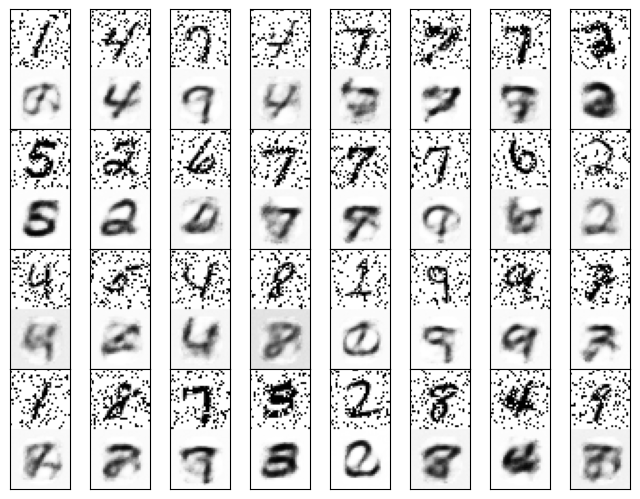

Validation: 0it [00:00, ?it/s]

val/reconstructions at 3438


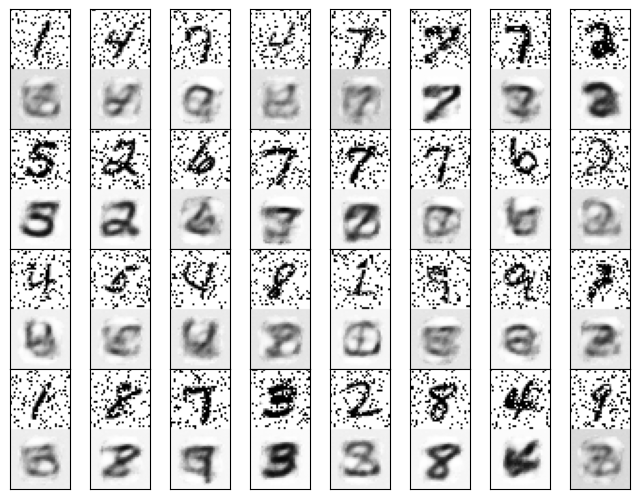

In [9]:
# We need some jupyter magic to plot inline
%matplotlib inline

epochs = 5
logger = run.build_logger("denoisingautoencoder", datamodule_name="MNIST", task="reconstruction")
run._train(model, logger, datamodule, epochs)

## Sparse Autoencoder

In all the previous models we face a fundamental problem for neural architectures: 
> It's not interpretable

The latent code we produce is not interpretable, meaning we cannot know which of the indecies of the latent vector is encoding which part of the feature. In vision tasks this a relativly easy to visualize problem, but imagine architectures for audio or vibration signals, this might be harder.  

We'd have to at least cluster the latent code and compare it to known targets. The sparse encoder is injecting an additional loss function to force a sparse constraint on the latent code. The sparse constraint is a mathematical expectation formulated over the latent code:

$\hat{p}_{j}^{(l)} = \frac{1}{N}\sum_{n=1}^{N}[a_{j}^{(l)}(x^{i})] \approx p$

There are multiple ways to enforce this expectation. The additional loss function needs to penalize large $p$, in order to force the vector to sparsity. Sparsity wants small propabilities in each vector, for low representational meaning. 

> A sparse vector tries to apply meaning to the indecies of vectors, ideally every index not related to the representational task should be 0, thus the sparse vector often has relativly many zero or low values.

These are the steps to enforce the sparsity constraint on the latent code:
* Apply an additional activation (sigmoid) on latent code.
* Average the batch dimension with size $N$.
* Now we are left with a 1d latent code of size $z$ for each batch.
* Apply the loss function to measure how well the above expectation is met.
* Add the sparsity loss to the reconstruction loss
* Backpropagate
* Repeat 🎉

To penalize large activations in the latent code activations, we'll use this loss: $L_{s} = \sum_{j=1}^{J} \log(1 + (\hat{p}_{j}^{(l)})^{2})$

This loss is a combination takes parts of the above mentioned square loss (square the probability) adding $1$ and taking the natural logarithm and summing it up. This way we can penalize high probabilities in the bottleneck activations.

> Note the $1+$ in $\log(1 + (\hat{p}_{j}^{(l)})^{2})$ takes care of very low probabilities running towards zero not beeing negative. Negative losses can cause harm here, resulting in NaN values for backpropagation.


In [12]:
from autoencoders.models.deep import DeepEncoder, DeepDecoder
from autoencoder.models.sparse import SparseBottleneck

In [11]:
input_shape = (1, 32, 32)
latent_dim = 20
depth = 3
alpha = 0.01
noise_ratio = 0.25
sparsity_loss = "log"
encoder = DeepEncoder(input_shape, depth, latent_dim)
decoder = DeepDecoder(latent_dim, depth, input_shape)
bottleneck = SparseBottleneck(latent_dim, sparsity_loss)
model = AutoEncoder(encoder, bottleneck, decoder, lr=alpha, noise_ratio=noise_ratio, recon_loss="rmse", prevent_tb_logging=True)
print(model)